In [2]:
'''
--------------------         README         -------------------------
Result 1 :  Best performing models : ANN and linear regression.
            they both achieve MAE ~ 0.64 and r2_score ~ 0.92
            which is compared to persistence model's scores MAE ~ 0.84 and r2_score ~ 0.87

Result 2 :  Best outlier detection assessed visually and with constraints of 
            analyst finding only anomaly for a certain period of a week.
            DBSCAN, model can be found below.
            this model is deployed to api also, the output is in json format,
            with consecutive days and index start, index end of anomaly period present as output


Exercise 1 : Weather forecasting of next 48 hours for day ahead bidding
Approach :
Data preprocessing -  
    fill missing values : 
        looking at the dataset given, there were a lot of missing values in some columns,
        first these missing values need to be filled accordingly for each of the columns in a way that logically fits them.

        for not losing seasonality affect in data while filling missing values, rolling window imputation considered,
        but the lack of strong presence of seasonality or trend, simple linear interpolation was used instead.

        first few rows will have nans even after interpolation, we can drop those as they are very small part of our total dataset
        and removing them will not cause any harm to time series since they are at the beginning itself.
    scale values :
        scaling values can help some models like neural networks perform better, so a scalers such MinMaxScaler, StandardScaler 
        are tried out. The model was tried out with both scaled and unscaled dataset.
    pca : 
        Principal Component Analysis creates new vectors (principal components) from the data points, 
        it's use here is to try reducing the dimension of the dataset features for reasons :
            Overfitting: Models may become too specialized to the training data, failing to generalize well to new, unseen data.
            Noise amplification: Minor variations in the data become amplified, making it harder to identify meaningful patterns.
            Feature Correlation: In high-dimensional spaces, features tend to be highly correlated, making it challenging to identify independent and meaningful relationships between variables.
            Computational Complexity: Analyzing high-dimensional data can be computationally expensive, especially for traditional statistical methods.
            Interpretability: It becomes increasingly difficult to understand and interpret the relationships between features and the resulting models.

feature creation - 
    existing columns in data do not show much dependability of wind_speed_avg on them, so need to create more features
    new features : lagged values of existing columns
                   rolling statistics of existing columns
                   timestamp features
                   interaction features
    their correlation with the target variable show their need and creation is justified

modeling -
    several models were tried out with scaled/unscaled features, principal components and raw values.
    best performing models : ANN and linear regression.
        they both achieve MAE ~ 0.64 and r2_score ~ 0.92
        which is compared to persistence model's scores MAE ~ 0.84 and r2_score ~ 0.87


Exercise 2: Anomaly detection in data given for 5 sensors
Approach :
Data preprocessing - 
    existing columns do not seem to have any missing values, but for out ease of data handling, we add date column
    for the data given.
    scaling of data for use with neural networks was done

feature creation - 
    for trying out different models that use different approach of finding patterns in data,
    some of the features are added in the dataset.
    new features :  timestamp features
                    a feature combining data from all 5 sensors

modeling -
    different approaches of anomaly detection were tried with both scaled/unscaled data :
        - an autoencoder method was implemented, using reconstruction error to detect anomaly.
        this uses the combined column as its input.
        - a decision tree classifier was implemented, since we have lablled data thanks to the analyst,
        although this fails to perform well, due to various reasons, but can be majorly blamed on class imbalanced
        - support vector machines, isolation forest, tsod range detector was thrown at the data to detect
        anomalies for specific time period that analyst mentioned.
        - DBSCAN was implemented which fulfilled both conditions of detecting anomaly in data analyst had labelled
        and not finding any anomaly for any other time before the end of september month.

DBSCAN was selected due to the condition of only one anomaly reported before the month of september ended.
so no other anomaly should be the output of the model, this condition was only fulfilled by the DBSCAN model.

while some other models did predict the labelled anomaly correctly, they also pointed other anomalies in data
before the month of september ended, this is the constraint we had put on our model's detected anomalies.
Due to the analyst's obervations mentioned
    
'''

"\n--------------------         README         -------------------------\nResult 1 :  Best performing models : ANN and linear regression.\n            they both achieve MAE ~ 0.64 and r2_score ~ 0.92\n            which is compared to persistence model's scores MAE ~ 0.84 and r2_score ~ 0.87\n\nResult 2 :  Best outlier detection assessed visually and with constraints of \n            analyst finding only anomaly for a certain period of a week.\n            DBSCAN, model can be found below.\n            this model is deployed to api also, the output is in json format,\n            with consecutive days and index start, index end of anomaly period present as output\n\n\nExercise 1 : Weather forecasting of next 48 hours for day ahead bidding\nApproach :\nData preprocessing -  \n    fill missing values : \n        looking at the dataset given, there were a lot of missing values in some columns,\n        first these missing values need to be filled accordingly for each of the columns in a wa

In [3]:
# common import statements are here, rest particular ones are in the cell itself
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import mode
import tensorflow as tf
import keras
from copy import copy, deepcopy

import warnings
warnings.simplefilter(action='ignore',category=[UserWarning, FutureWarning])

### utils

In [4]:
# helper functions to be used in code later on

def fill_na_with_rolling_window(data=None, col=None, series=None, n_step=None):
    '''
    DESCR : a function to use a rolling window logic to fill the missing values in data,
        this method can help fill missing values without losing the effect of seasonality if present in the data.
    Args : 
        - data : dataframe containing missing values
        - col : specify which column to fill missing values in
        - series : could be given instead of data and col args, not yet implemented
        - n_step : number of steps of rolling window
    '''
    # check if column is given, otherwise raise error
    if col:
        if isinstance(data,pd.DataFrame):
            data['n_roll'] = data[col].rolling(n_step).mean()
            data.loc[data[col].isna(), col] = data.loc[data[col].isna(),'n_roll']
        # elif isinstance(series,pd.Series):
        #     data['n_roll'] = data[col].rolling(n_step)
        #     data.loc[data[col].isna(),col] = data.loc[data[col].isna(),'n_roll']
        else: raise Exception("you have not specified a column name to fill missing value in")
    # drop the column added with rolling window values for each row before returning
    return data.drop('n_roll',axis=1)

# without scaling model did not perform so well, try scaling the features
def scale_features(df, name_of_features=[], type_of_features_to_scale=['float'], scaler=MinMaxScaler(), fit=True):
    '''
    DESCR : a function to scale features before feeding into the model, scaling features before feeding into the
        model can help some models' performance
    Args : 
        - df : dataframe containing the features
        - name_of_features : specify name of features to scale, can be given instead of type of features
            to specifically scale features
        - type_of_features_to_scale : specify which type of features to scale, could be used to specify
            all features of specific type, could be given instead of names of the features.
            by default all float features are to be scaled if name of features are not given
                because of the current use case
        - scaler : specify which scaler to use to scale features with, by default minmaxscaler is used from sklearn
        - fit : boolean to specify if scaler needs to be fit on the data before scaling them
    '''
    # map to return scaler used to scale each feature column, not using it, hence not implemented
    scaler_map = {}
    # check whether to scale using name of features of type of features  to scale
    if (len(name_of_features)==0) and type(name_of_features)==list:
        # iterate over all features and check whether they need to be scaled or not
        for col_no, pair in enumerate(df.dtypes.items()):
            if pair[1] in type_of_features_to_scale:
                # scaler expects df, so do iloc this way, else it will give a series
                if fit:
                    df.iloc[:,col_no:col_no+1] = scaler.fit_transform(df.iloc[:,col_no:col_no+1])
                else:
                    df.iloc[:,col_no:col_no+1] = scaler.transform(df.iloc[:,col_no:col_no+1])
                # scaler_map[pair[0]] = scaler
    else:
        # iterate over all features and check whether they need to be scaled or not
        for col_no, pair in enumerate(df.dtypes.items()):
            if pair[0] in name_of_features:
                # scaler expects df, so do iloc this way, else it will give a series
                if fit:
                    df.iloc[:,col_no:col_no+1] = scaler.fit_transform(df.iloc[:,col_no:col_no+1])
                else:
                    df.iloc[:,col_no:col_no+1] = scaler.transform(df.iloc[:,col_no:col_no+1])
                # scaler_map[pair[0]] = scaler
    # return scaled dataframe and scaler map
    return (df, scaler_map)



## Weather Forecasting

In [5]:
# reading weather forecasting dataset and renaming columns for ease of data handling
weather_data = pd.read_csv('data/spark_renewable_ds_forecast_challenge.csv', parse_dates=False)
weather_data.rename(columns={'TimeStamp (UTC)':'ts',
                             'WindDirection Avg':'wind_direction',
                             'WindSpeed Avg':'wind_speed_avg',
                             'WindSpeed StdDev':'wind_speed_std',
                             'T AMB Avg':'temp',
                             'In AirDensity Avg':'density'},inplace=True)

# convert timestamp column to datetime from object
weather_data['ts'] = pd.to_datetime(weather_data['ts'],utc=True)
print(weather_data.shape)
# storing original columns in case need to specifically access original dataframe
original_weather_cols = weather_data.columns
weather_data.head()

(8760, 6)


,ts,wind_direction,wind_speed_avg,wind_speed_std,temp,density
0,2021-01-01 06:00:00+00:00,NaN,5.110103,NaN,-0.896897,NaN
1,2021-01-01 07:00:00+00:00,NaN,5.221429,NaN,-0.847589,NaN
2,2021-01-01 08:00:00+00:00,NaN,5.411667,NaN,-1.000000,NaN
3,2021-01-01 09:00:00+00:00,NaN,4.855000,NaN,-1.000000,NaN
4,2021-01-01 10:00:00+00:00,NaN,4.369630,NaN,-0.398102,NaN


Text(0.5, 1.0, 'correlation heatmap')

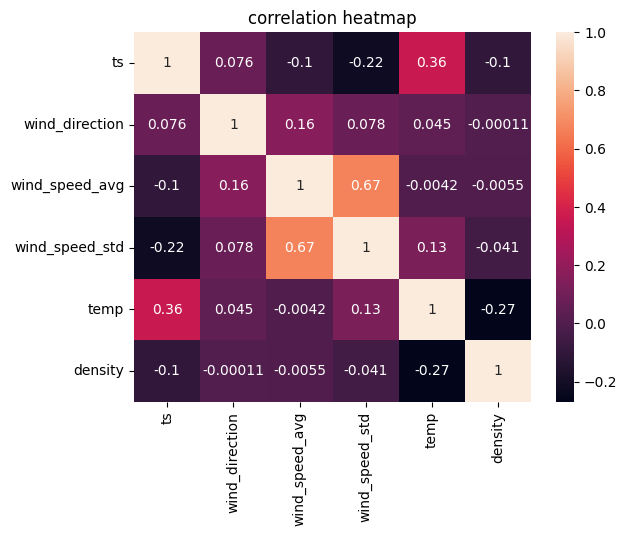

In [6]:
# checking for correlation
# no useful correlation can be seen in the original data, 
# we probably will need to extract features from these original columns
sns.heatmap(weather_data.corr(), annot=True,)
plt.title('correlation heatmap')

In [7]:
# checking time intervals in data
# checking frequency of time series values
(weather_data.ts - weather_data.ts.shift(1)).dt.total_seconds().unique()

array([  nan, 3600.])

Text(0.5, 0, 'index')

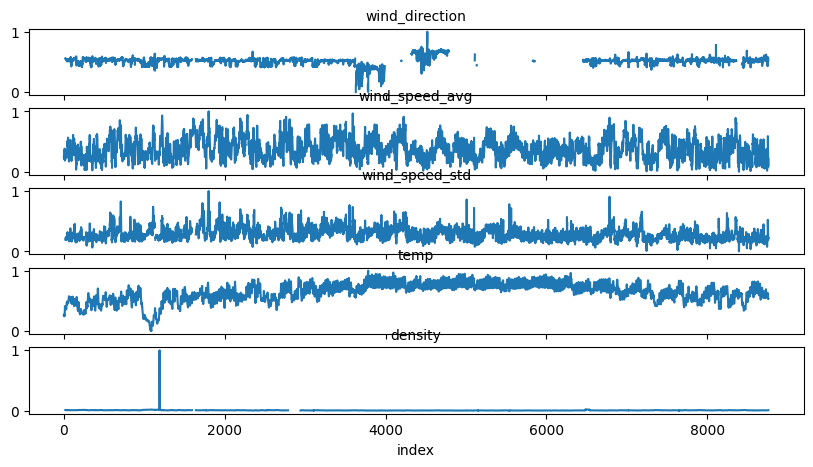

In [8]:
# check if nans occuring are together, also see if any observable patterns for wind speed and other
# indicating sensor issue etc
fig,ax = plt.subplots(weather_data[original_weather_cols].shape[1]-1,1,figsize=(10,5),sharex=True)
scaler = MinMaxScaler()
for i,col in enumerate(weather_data[original_weather_cols].columns[1:]):
    ax[i].plot(scaler.fit_transform(weather_data[col].values.reshape(-1,1)))
    ax[i].set_title(col,size=10)
plt.xlabel('index')
plt.show()

In [9]:
# fill missing values in wind speed avg with spline interpolation (linear interpolation also does not show much difference from spline)
# might use linear instead of spline for the sake of less complexity
# plt.figure(figsize=(14,4))
# plt.plot(weather_data.wind_speed_avg.interpolate(option='linear').iloc[range(0,weather_data.shape[0],5)])
weather_data.interpolate(option='linear',inplace=True)
print("nan in wind speed",weather_data['wind_speed_avg'].isna().sum())

nan in wind speed 0


In [10]:
# check which columns have nans left in them
weather_data.isna().sum(axis=0)

ts                 0
wind_direction    19
wind_speed_avg     0
wind_speed_std    19
temp               0
density           19
dtype: int64

In [11]:
# still seeing nans, because interpolation did not fill nans at the start
# there is only 19 rows with nans now, which we drop because we have large enough data compared to 19 rows
# we can store persistence predictions here, so we do not miss out on one row when we take shift of column for it
persistence_predictions = weather_data.wind_speed_avg.shift(1)
weather_data.dropna(axis=0,inplace=True)

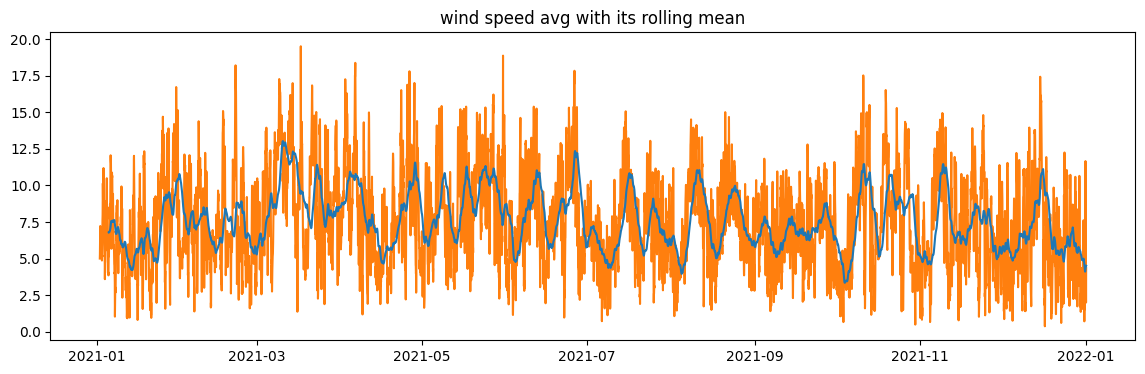

In [12]:
# plotting data to see if any visible trend or seasonality present in the data set
# plot raw values with their rolling mean
plt.figure(figsize=(14,4))
plt.plot(weather_data.set_index('ts').wind_speed_avg.rolling(80).mean(),zorder=13)
plt.plot(weather_data.set_index('ts').wind_speed_avg)
plt.title('wind speed avg with its rolling mean')
plt.show()
plt.close()

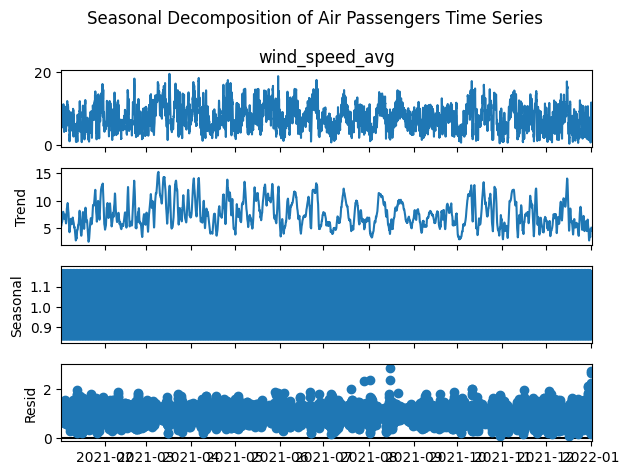

In [13]:
# check trend, seasonality after decomposition of components using statsmodels api
result = seasonal_decompose(weather_data.set_index('ts')['wind_speed_avg'].fillna(weather_data['wind_speed_avg'].mean()), 
                            model='multiplicative', extrapolate_trend='freq')
result.plot()
plt.suptitle('Seasonal Decomposition of Air Passengers Time Series')
plt.tight_layout()
plt.show()
plt.close()


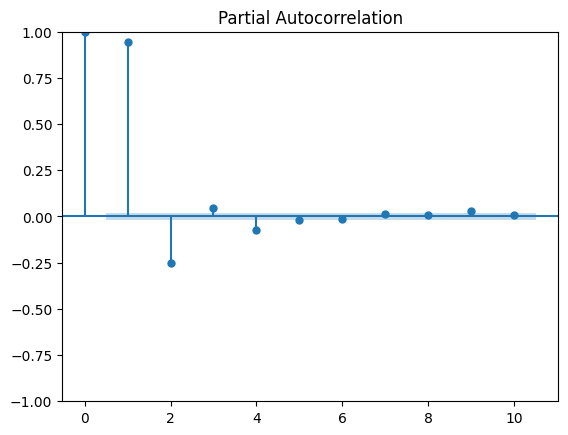

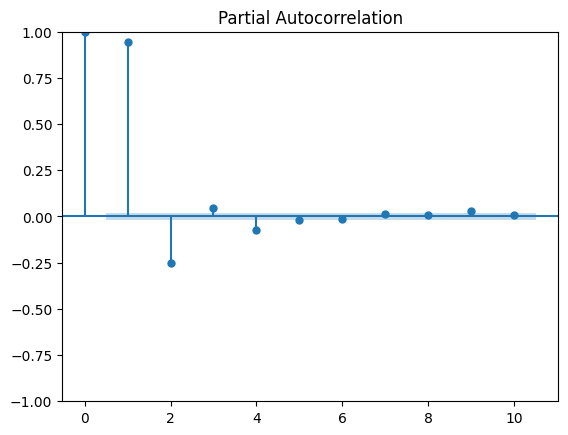

In [14]:
# checking for partial autocorrelation to see which past values are highly correlated for the wind_speed_avg column
# this helps in specifying how many past values would be helpful for the mode to determine the new predicted value
from statsmodels.graphics import tsaplots
tsaplots.plot_pacf(weather_data['wind_speed_avg'].values.squeeze(), lags=10, method="ywm")

In [15]:
# creating ts features : 
weather_data['hod'] = weather_data['ts'].dt.hour.astype(float)
weather_data['moy'] = weather_data['ts'].dt.month.astype(float)
ts_features = ['hod','moy']

In [16]:
# creating interaction features :
weather_data['temp_density_interaction'] = weather_data['temp'] * weather_data['density']
weather_data['temp_speed_interaction'] = weather_data['temp'] * weather_data['wind_speed_std']
weather_data['temp_direction_interaction'] = weather_data['temp'] * weather_data['wind_direction']
weather_data['speed_direction_interaction'] = weather_data['wind_speed_std'] * weather_data['wind_direction']

interaction_features = ['temp_density_interaction','temp_speed_interaction','temp_direction_interaction','speed_direction_interaction']

In [17]:
# creating rolling features :
n3 = 3
weather_data[f'rolling_{n3}_mean_std'] = weather_data.wind_speed_std.rolling(n3).mean()
# weather_data['rolling_5_mean_std'] = weather_data.wind_speed_std.rolling(5).mean()
weather_data[f'rolling_{n3}_mean_temp'] = weather_data.temp.rolling(n3).mean()
weather_data[f'rolling_{n3}_mean_density'] = weather_data.density.rolling(n3).mean()

weather_data[f'rollig_{n3}_var_std'] = weather_data.wind_speed_std.rolling(n3).var()
weather_data[f'rollig_{n3}_var_temp'] = weather_data.temp.rolling(n3).var()
weather_data[f'rollig_{n3}_var_density'] = weather_data.density.rolling(n3).var()

rolling_mean_features = [f'rolling_{n3}_mean_std',f'rolling_{n3}_mean_temp',f'rolling_{n3}_mean_density']
rolling_var_features = [f'rollig_{n3}_var_std',f'rollig_{n3}_var_temp',f'rollig_{n3}_var_density']

In [18]:
# creating lag features :
def add_lag_features(df,col_name,timestep):
    timestep_features = []
    for i in range(1,timestep+1):
        df[f'{i}_lag_{col_name}'] = df[col_name].shift(i)
        timestep_features.append(f'{i}_lag_{col_name}')
    return df, timestep_features

# pcaf shows lag 3 is nicely autocorrelated
n1=3
weather_data, lag_speed_features = add_lag_features(weather_data, 'wind_speed_avg', n1)
n2=3
weather_data, lag_temp_features = add_lag_features(weather_data, 'temp', n2)
weather_data, lag_density_features = add_lag_features(weather_data, 'density', n2)
weather_data, lag_direction_features = add_lag_features(weather_data, 'wind_direction', n2)
weather_data, lag_wind_std_features = add_lag_features(weather_data, 'wind_speed_std',n2)

# need to eliminate first n rows since their lag features will be nan
weather_data = weather_data.iloc[max(n1,n2,n3):,:]

In [19]:
# # was using polynomial features to detect and create features from the dataset, 
# # not using it, instead creating features manually and feeding them to the model
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures()
# poly_data = poly.fit_transform(weather_data[original_weather_cols].iloc[:,1:])

In [20]:
# creating variables which will be helpful in specifying columns being referred for input features and target variables
# helpful if we want to not include some features quickly, just comment it out
target_col = 'wind_speed_avg'
feature_list = []
feature_list.extend(lag_speed_features)
# feature_list.extend(ts_features)
feature_list.extend(interaction_features)
feature_list.extend(rolling_mean_features)
feature_list.extend(rolling_var_features)
feature_list.extend(lag_temp_features)
feature_list.extend(lag_density_features)
feature_list.extend(lag_direction_features)
feature_list.extend(lag_wind_std_features)

In [21]:
# using pca to reduce number of features
# pca works by creating new principal components (vectors), that closely resemble the data points originally
# reducing dimensions can help some models generalize better and reduce overfitting also
from sklearn.decomposition import PCA
pca = PCA(n_components=0.8)
pca.fit(weather_data[feature_list])

# scaling target column data and storing scaler for future inverse transform of the predictions
target_col_scaler = MinMaxScaler()
target_col_scaler.fit_transform(weather_data[target_col].values.reshape(-1,1))

# scaling feature list using util function
weather_data, _ = scale_features(weather_data, name_of_features=feature_list, scaler=MinMaxScaler(), fit=True)

In [22]:
# using Random forest regressor model to predict target values by splitting data with pivotal nodes
# learned during training phase and then proceed to give avg values of data points at each split end (leaf node)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=50, max_depth=9,#int(0.7*(len(feature_list))), 
                              random_state=42, min_weight_fraction_leaf=0.001, 
                              min_samples_leaf=5, min_samples_split=40
                            )

# x_train, x_test, y_train, y_test = train_test_split(poly_data, poly_data, test_size=0.1, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(weather_data[feature_list], weather_data[target_col], test_size=0.1, shuffle=False)
# PCA not improving things
# x_train = pca.transform(x_train)
# x_test = pca.transform(x_test)

# train_set, test_set = [x_train,y_train], [x_train,y_train]
train_set, test_set = [x_train,y_train], [x_test,y_test]

model.fit(train_set[0], train_set[1])
predictions = model.predict(test_set[0])

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))
# test_set[1] = target_col_scaler.inverse_transform(test_set[1].reshape(-1,1))

print("errors for random forest regressor model :-")
print("\tMAE",mean_absolute_error(test_set[1], predictions))
print("\tRMSE",root_mean_squared_error(test_set[1], predictions))
print('\tr2',r2_score(test_set[1], predictions))


errors for random forest regressor model :-
	MAE 0.7394833504212666
	RMSE 0.9746517456913085
	r2 0.9077618987437789


In [23]:
# errors for persistence model's predictions
print("errors for persistence model :-")
print("\tMAE",mean_absolute_error(test_set[1], persistence_predictions.loc[test_set[1].index]))
print("\tRMSE",root_mean_squared_error(test_set[1], persistence_predictions.loc[test_set[1].index]))
print('\tr2',r2_score(test_set[1], persistence_predictions.loc[test_set[1].index]))

errors for persistence model :-
	MAE 0.847292113665904
	RMSE 1.1297518121625048
	r2 0.8760696952635254


In [24]:
# printing feature importance for top 5 features considered useful by random forest regressor model above
# pd.Series(model.feature_importances_,index=feature_list).nlargest(5).plot(kind='barh')

In [25]:
# # code to save and load the model as pickle file, 
# # only uncomment this code if you want to save the model again
# import pickle
# # save
# with open('wind_forecast_model.pkl','wb') as f:
#     pickle.dump(model,f)

# # load
# import pickle
# with open('wind_forecast_model.pkl', 'rb') as f:
#     model = pickle.load(f)

# model.predict(X[0:1])

In [26]:
# using xgboost model to predict the wind_speed_avg values, 
# not using the xgboost model because it does not give very good scores, will need more looking into
import xgboost as xg

# Train and test set are converted to DMatrix objects, 
# as it is required by learning API. 
train_dmatrix = xg.DMatrix(data = train_set[0], label = train_set[1]) 
test_dmatrix = xg.DMatrix(data = test_set[0], label = test_set[1]) 


param = {"booster":"gblinear", "objective":"reg:linear"} 
  
xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
predictions = xgb_r.predict(test_dmatrix) 

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

print("errors for xgboost model :-")
print("\tMAE",mean_absolute_error(test_set[1], predictions))
print("\tRMSE",root_mean_squared_error(test_set[1], predictions))
print('\tr2',r2_score(test_set[1], predictions))

Exception ignored on calling ctypes callback function: <function _log_callback at 0x3069bf7e0>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/weather-forecast/lib/python3.12/site-packages/xgboost/core.py", line 158, in _log_callback
    warnings.warn(smsg, UserWarning)
TypeError: issubclass() arg 2 must be a class, a tuple of classes, or a union


errors for xgboost model :-
	MAE 1.3321019963580207
	RMSE 1.6238903921210543
	r2 0.7439499594766248


In [27]:
from sklearn.linear_model import LinearRegression, PassiveAggressiveRegressor

model = LinearRegression()

model.fit(train_set[0], train_set[1])
predictions = model.predict(test_set[0])

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))
print("errors for linear regression model :-")
print("\tMAE",mean_absolute_error(test_set[1], predictions))
print("\tRMSE",root_mean_squared_error(test_set[1], predictions))
print('\tr2',r2_score(test_set[1], predictions))

errors for linear regression model :-
	MAE 0.6455760261966363
	RMSE 0.869074238896857
	r2 0.9266626559256362


(array([  6.,  26., 124., 323., 299.,  65.,  24.,   5.,   1.,   1.]),
 array([-3.15272444, -2.34865825, -1.54459207, -0.74052588,  0.06354031,
         0.86760649,  1.67167268,  2.47573887,  3.27980506,  4.08387124,
         4.88793743]),
 <BarContainer object of 10 artists>)

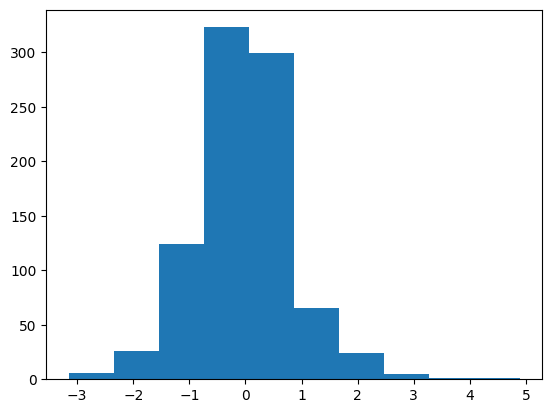

In [28]:
# check if residuals are normally distributed for linear regression model
plt.hist(predictions - test_set[1])

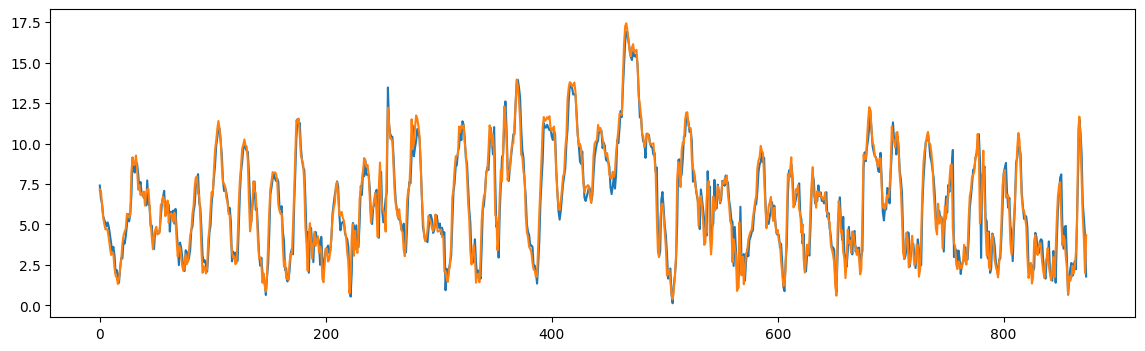

In [29]:
# # analysing predictions
plt.figure(figsize=(14,4))
plt.plot(predictions)
plt.plot(y_test.reset_index(drop=True))
# plt.plot(weather_data.loc[y_test.index]['wind_direction'].reset_index(drop=True))

In [30]:
raise Exception('''i want the code to stop here if run all cells is excecuted \n cells below will take some time to run
                \nremove this cell and execute run all, to run all the cells''')

Exception: i want the code to stop here if run all cells is excecuted 
 cells below will take some time to run
                
remove this cell and execute run all, to run all the cells

In [125]:
import keras
model = keras.Sequential()
scaler = MinMaxScaler()

# train_set, test_set = [x_train,y_train], [x_train,y_train]
train_set, test_set = [x_train,y_train], [x_test,y_test]

scaler.fit(weather_data[feature_list])
train_set[0] = scaler.transform(train_set[0])
test_set[0] = scaler.transform(test_set[0])
feature_scaler = deepcopy(scaler)
scaler.fit(weather_data[target_col].values.reshape(-1,1))
train_set[1] = scaler.transform(train_set[1].values.reshape(-1,1))

data_tensor = tf.convert_to_tensor(train_set[0], dtype=tf.float32)

# input_shape=(train_set[0].shape[1],)
model.add(keras.layers.Dense(data_tensor.shape[1], activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam')

model.fit(data_tensor, train_set[1], batch_size=32, epochs=100, validation_split=0.2, verbose=0)
# model.summary()
predictions = model.predict(test_set[0],)

predictions = scaler.inverse_transform(predictions)

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))
print("r2 score",r2_score(test_set[1], predictions))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE 0.6819218629024354
RMSE 0.9047765130701376
r2 score 0.920513374325679


In [1296]:
# LSTM approach
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

data = train_set[0].reshape(-1,len(feature_list),1)
# Define the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Fit the model
model.fit(data, train_set[1], epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
# model.summary()
predictions = model.predict(test_set[0],)

predictions = scaler.inverse_transform(predictions)

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))
print("r2 score",r2_score(test_set[1], predictions))

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0341 - val_loss: 0.0088
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0094 - val_loss: 0.0059
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0066 - val_loss: 0.0051
Epoch 6/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0060 - val_loss: 0.0069
Epoch 7/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 8/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 9/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 10/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 11/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 12/100
197/197 ━━━━━━━━━

In [214]:
# # not used
# # checking accuracy for model's prediction for next 48 hours
# # predictions for next 48 hours should be compared with prediction of 48 hours using persistence model
# # MAE in this will give how off the model's predictions are for next 48 hours

# from copy import copy, deepcopy
# def get_predictions_next_hrs(lag_feature_col, df, how_many_preds):
#     if isinstance(df,pd.DataFrame):
#         c = df.to_numpy()
#     c = deepcopy(df)
#     if type(model) == keras.src.models.sequential.Sequential:
#         c = c.reshape(1,len(feature_list))
#     else:
#         c = c.reshape(len(feature_list), 1)
#     next_48_preds = []
#     # latest_lag_col = min([i for i in c[feature_list].columns if lag_feature_col in i])
#     latest_lag_col_idx = min([i for i,name in enumerate(feature_list) if lag_feature_col in name])
#     # print([i for i in c[feature_list].columns if lag_feature_col in i])
#     for pred_no in range(how_many_preds):
#         print(c.shape)
#         pred = model.predict(c)[0]
#         if isinstance(pred,(list,np.ndarray)):
#             pred = pred[0]
#         next_48_preds.append(pred)
#         # print(c[latest_lag_col])
#         c[latest_lag_col_idx] = pred
#         # print(c[latest_lag_col])
#     next_48_preds = scaler.inverse_transform(np.reshape(next_48_preds, (-1,1)))
#     return next_48_preds.flatten()

# def get_persistence_next_hrs(prediction_series, how_many_preds):
#     persistence_predictions_next_48 = []
#     for pred in prediction_series:
#         persistence_predictions_next_48.append([pred for i in range(how_many_preds)])

#     return persistence_predictions_next_48
        
# next_48_hr_predictions = []
# for row in test_set[0][:10]:
#     predictions_next_48 = get_predictions_next_hrs('wind_speed_avg', row, 48)
#     next_48_hr_predictions.append(predictions_next_48)
#     # if len(next_48_hr_predictions) == 0:
#     #     next_48_hr_predictions = predictions_next_48
#     # else:
#     #     np.vstack([next_48_hr_predictions, predictions_next_48])
# persistence_predictions_next_48 = get_persistence_next_hrs(persistence_predictions[test_set[1].index][:10], 48)
# # next_48_hr_predictions

In [215]:
# # not used
# # checking accuracy for model's prediction for next 48 hours
# # predictions for next 48 hours should be compared with prediction of 48 hours using persistence model
# # MAE in this will give how off the model's predictions are for next 48 hours

# # accuracy for time horizon
# time_horizon =48
# predictions_next_48 = []
# for i in range( 0,test_set[1].shape[0] - time_horizon):
#     predictions_next_48.append((predictions[i: i+time_horizon]).flatten())
# predictions_next_48 = np.array(predictions_next_48)

# actual_next_48 = []
# for i in range( 0,test_set[1].shape[0] - time_horizon):
#     actual_next_48.append(test_set[1].iloc[i: i+time_horizon])
# actual_next_48 = np.array(actual_next_48).reshape(predictions_next_48.shape)

# time_horizon =48
# persistence_predictions_next_48 = []
# for i in range( 0,test_set[1].shape[0] - time_horizon):
#     persistence_predictions_next_48.append(persistence_predictions[test_set[1].index].iloc[i: i+time_horizon])
# persistence_predictions_next_48 = np.array(persistence_predictions_next_48).reshape(predictions_next_48.shape)

# # mean absolute error for next 48 hours
# print("persist",np.mean(list(map(sum,abs(persistence_predictions_next_48 - actual_next_48)))))
# print("model",np.mean(list(map(sum,abs(predictions_next_48 - actual_next_48)))))

## Anomaly Detection

In [70]:
# reading time series data and indexing date column for helping with observing time series data over the time period
time_series = pd.read_csv("data/anomaly_detection.csv")
time_series['date'] = pd.date_range(start='1/1/2016', end='30/12/2016')
print(time_series.shape)
time_series.head()

# storing the original columns for when only original dataset needs to be accessed
original_cols = ['CEACC','CCDEF','FAXAE','FBFFD','EDDAB']

(365, 6)


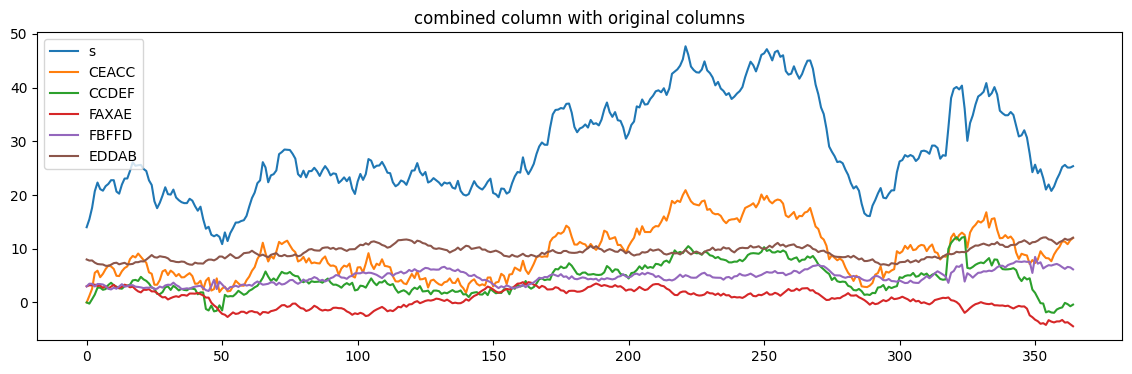

In [71]:
# reasons for taking sum instead of multiply, abs(sum) :
# 0 values present for sensor, z_score of additive seem to make the anomaly look reasonable

# trying different approaches to combine data into single column time series
time_series['s'] = time_series[original_cols].sum(axis=1)
# time_series['s'] = time_series['CEACC'] * time_series['CCDEF'] * time_series['FAXAE'] * time_series['FBFFD'] * time_series['EDDAB']

# trying out whether eliminating some initial columns help multivariate models to better predict anomalies
# time_series['s'] = time_series[['CEACC','FAXAE','CCDEF']].sum(axis=1)
plt.figure(figsize=(14,4))
time_series.s.plot()
time_series.CEACC.plot()
time_series.CCDEF.plot()
time_series.FAXAE.plot()
time_series.FBFFD.plot()
time_series.EDDAB.plot()
plt.title("combined column with original columns")
plt.legend()
plt.show()
plt.close()

In [72]:
# # not used
# # trying dimensionality reduction using pca
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.8)
# pca.fit_transform(time_series[original_cols])
# time_series['pc_1'] = list(map(lambda x: x[0], pca.fit_transform(time_series[original_cols])))
# sns.barplot(pca.explained_variance_)

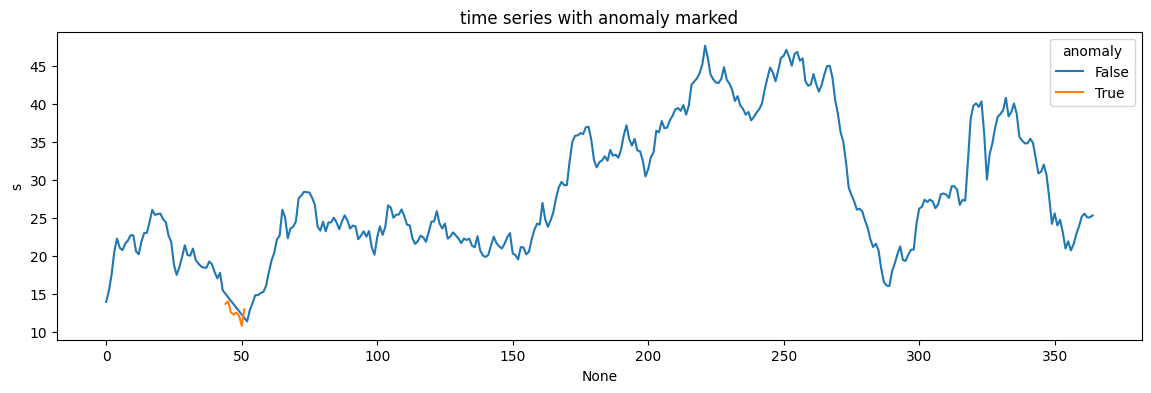

In [73]:
# specifying anomaly start and end data as stated by the analyst
anomaly_start_doy, anomaly_end_doy = pd.to_datetime('2016-02-14').day_of_year, pd.to_datetime('2016-02-21').day_of_year

# creating some features extracted using the date column earlier added to dataset
time_series['doy'] = time_series.date.dt.day_of_year
# mark the anomaly in the dataset
time_series['anomaly'] = False
time_series.loc[(time_series['doy']>=anomaly_start_doy) & (time_series['doy']<=anomaly_end_doy),'anomaly'] = True

plt.figure(figsize=(14,4))
sns.lineplot(data=time_series,y='s',x=time_series.index, hue='anomaly')
plt.title("time series with anomaly marked")
plt.show()
plt.close()

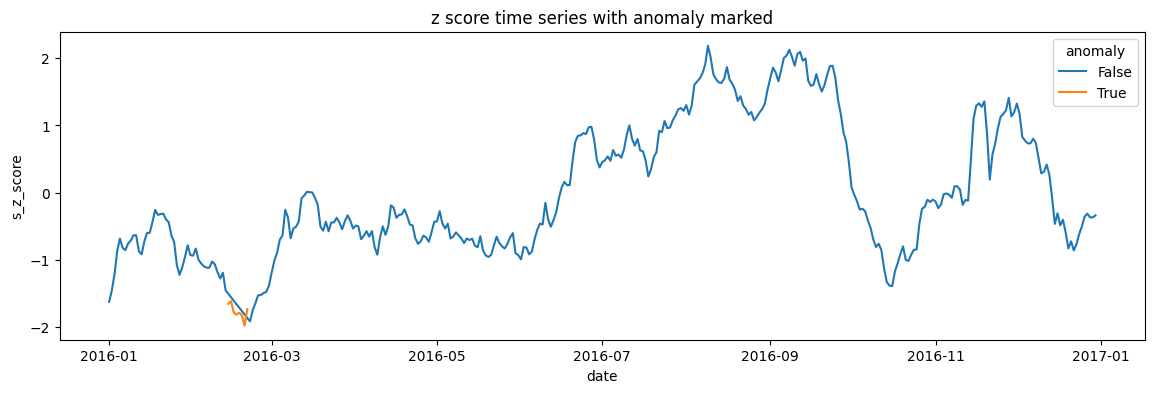

In [74]:
# plotting z scores of the earlier combined column, with anomaly marked in it
scaler = StandardScaler()
time_series['s_z_score'] = scaler.fit_transform(time_series['s'].values.reshape(-1,1))

plt.figure(figsize=(14,4))
sns.lineplot(data=time_series,y='s_z_score',x=time_series.date, hue='anomaly')

# using vlines to help mark the anomaly time period
# plt.vlines(x=pd.to_datetime('2016-02-14'),ymin=-2,ymax=2,linestyles='dashed',color='orange')
# plt.vlines(x=pd.to_datetime('2016-02-21'),ymin=-2,ymax=2,linestyles='dashed',color='orange')
plt.title("z score time series with anomaly marked")
plt.show()
plt.close()

In [75]:
# importing some packages and functions to be used below
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support


In [76]:
# trying simple autoencoder approach to see if reconstruction errors can help us predict the anomlaies in the dataset
# auto encoder work by learning a generalized manner of data, 
# and then when trying to predict the value of items again, 
# the non general data points will have higher error from their predicted values
# these can be considered as anomalies
# NOTE: Exclude datetime column again
# np.random.seed(42)
# converting data to tensors using tensorflow package
data_tensor = tf.convert_to_tensor(time_series['s'].values, dtype=tf.float32)

# Define the autoencoder model
# input_dim = time_series[original_cols].shape[1] - 1
input_dim = 1
encoding_dim = 10

# autoencoder network starts below
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=100,
                batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
# calculating MSE
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
                     axis=1)
# make as series with anomaly scores error for easier handling
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = time_series.index


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 903.4359
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 885.3463
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 910.8592
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 923.0984 
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 856.5477
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 934.7771
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 917.3453
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 894.8311
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 908.9787
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 877.8875
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 855.7569
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 902.4930
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 899.3971
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 834.1598
Epoch 15/100
1

In [77]:
# # saving and loading model using keras package
# # only uncomment this if want to save the model again
# autoencoder.save('model.keras')
# import keras
# a = keras.models.load_model('model.keras')
# a.summary()

In [78]:
# # trying out tsod rangedetector to detect anomalies in the time series
# import tsod
# rd = tsod.RangeDetector(0.01,2.0)
# anomalous = rd.detect(time_series['s'])
# # time_series['preds'] = res

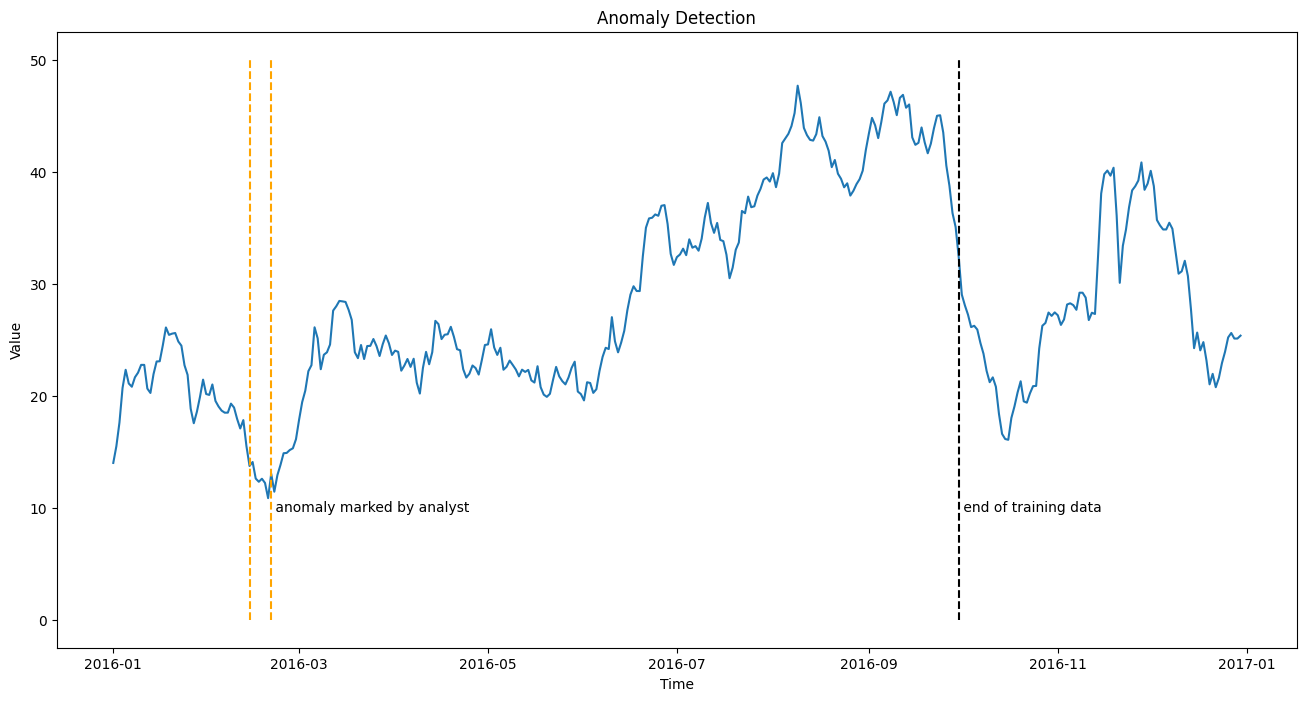

In [79]:
threshold = anomaly_scores.quantile(0.93)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
# precision, recall,\
#     f1_score, _ = precision_recall_fscore_support(
#         binary_labels, anomalous, average='binary')
# Plot the data with anomalies marked in red
plt.figure(figsize=(16, 8))
plt.plot(time_series['date'],
         time_series['s']
        # time_series[original_cols]
         )
plt.plot(time_series['date'][anomalous],
         time_series['s'][anomalous], 
        # time_series[original_cols][anomalous]
         'ro')
plt.vlines(x=pd.to_datetime('2016-02-14'),ymin=0,ymax=50,linestyles='dashed',color='orange')
plt.vlines(x=pd.to_datetime('2016-02-21'),ymin=0,ymax=50,linestyles='dashed',color='orange')
plt.text(pd.to_datetime('2016-02-21'), 10, " anomaly marked by analyst", rotation=0, verticalalignment='center')
plt.vlines(x=pd.to_datetime('2016-09-30'),ymin=0,ymax=50,linestyles='dashed',color='black')
plt.text(pd.to_datetime('2016-09-30'), 10, " end of training data", rotation=0, verticalalignment='center')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [80]:
# logic to calculate consecutive anomalous days, to implement conditions given of 

# a = pd.DataFrame({'a':anomalous,'date':time_series['date']})
# a['sess'] = a['a'].diff()
# a.loc[a['a']==False, 'sess'] = np.nan
# a.sess = a.sess.cumsum()
# a = a.groupby('sess').agg(
#     consecutive_days = ('a','count'),
#     start_date = ('date','first'),
#     end_date = ('date','last')
# )
# display(a)
# a = a.loc[(a['consecutive_days']>2) & (a['consecutive_days]<14)]
# prints the data in json format that needs to be returned from the api
# a.to_json(orient='records')

In [81]:
# making use of 5 original sensor columns given to classify anomalous data using decision tree classifier
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(class_weight={True:4,False:1}, max_depth=9,#int(0.7*(len(feature_list))), 
                              random_state=42, #min_weight_fraction_leaf=0.001, 
                              #min_samples_leaf=5, min_samples_split=40
                            )

train_indices = time_series.date<='2016-09-30'
test_indices = time_series.date>'2016-09-30'

x_train, x_test = time_series.loc[train_indices][original_cols], time_series.loc[test_indices][original_cols]
y_train, y_test = time_series.loc[train_indices]['anomaly'], time_series.loc[test_indices]['anomaly']
# PCA not improving things, so not using it
# x_train = pca.transform(x_train)
# x_test = pca.transform(x_test)

# train_set, test_set = [x_train,y_train], [x_train,y_train]
train_set, test_set = [x_train,y_train], [x_test,y_test]

# test_set[1] = target_col_scaler.inverse_transform(test_set[1].values.reshape(-1,1))

classifier.fit(train_set[0], train_set[1])
predictions = classifier.predict(test_set[0])

time_series.loc[test_indices,'preds'] = predictions

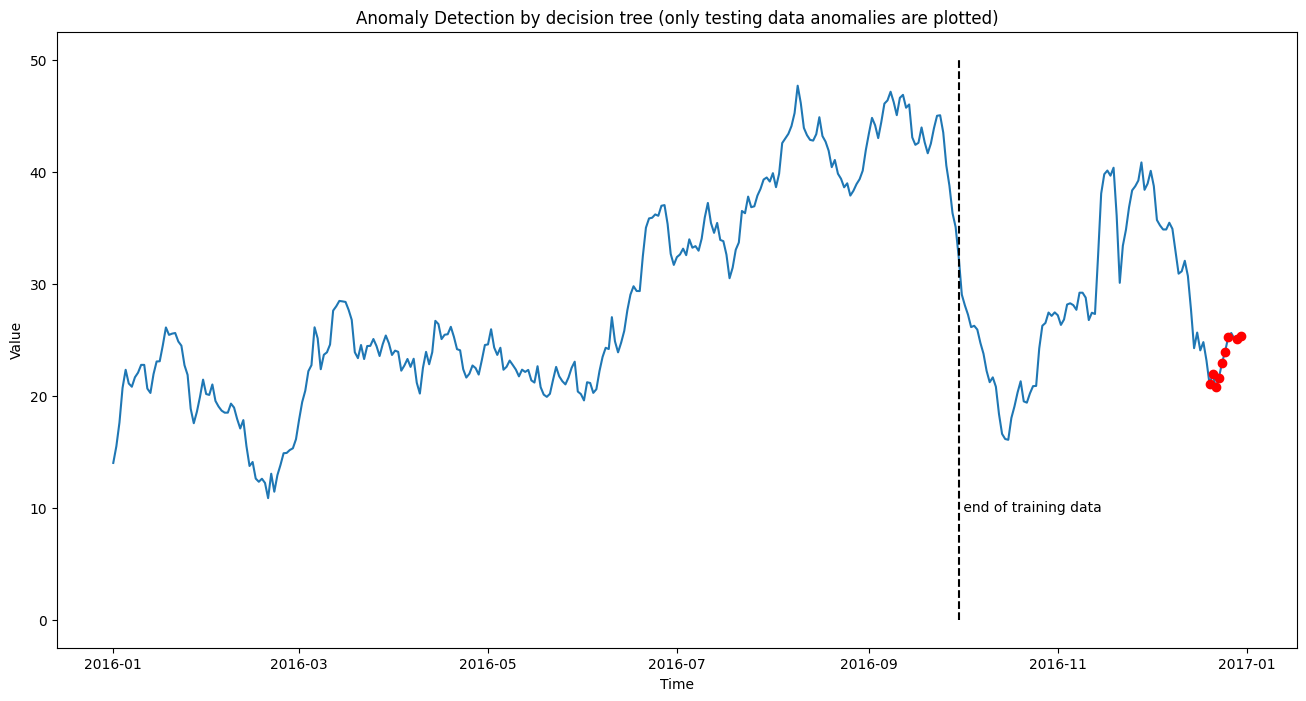

In [82]:
# plotting anomalies in original data given
plt.figure(figsize=(16, 8))
plt.plot(time_series['date'],
         time_series['s']
        # time_series[original_cols]
         )
plt.plot(time_series.loc[test_indices & time_series['preds'],'date'],
         time_series.loc[test_indices & time_series['preds'],'s'], 
        # time_series[original_cols][anomalous]
         'ro')

# using vlines to help see marked anomalous data better
# plt.vlines(x=pd.to_datetime('2016-02-14'),ymin=0,ymax=50,linestyles='dashed',color='orange')
# plt.vlines(x=pd.to_datetime('2016-02-21'),ymin=0,ymax=50,linestyles='dashed',color='orange')
plt.vlines(x=pd.to_datetime('2016-09-30'),ymin=0,ymax=50,linestyles='dashed',color='black')
plt.text(pd.to_datetime('2016-09-30'), 10, " end of training data", rotation=0, verticalalignment='center')
plt.title('Anomaly Detection by decision tree (only testing data anomalies are plotted)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [83]:
# making use of 5 original sensor columns given to classify anomalous data using support vector classifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train, y_train)
preds = clf.predict(x_test)
preds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [84]:
# # not implemented
# # making use of 5 original sensor columns given to classify anomalous data using isolation forest,
# from sklearn.ensemble import IsolationForest
# from sklearn.pipeline import make_pipeline
# clf = make_pipeline(StandardScaler(), IsolationForest())
# clf.fit(x_train, y_train)
# preds = clf.predict(x_test)
# time_series['preds'] = preds

Text(0.5, 1.0, 'clusters plotted with time series')

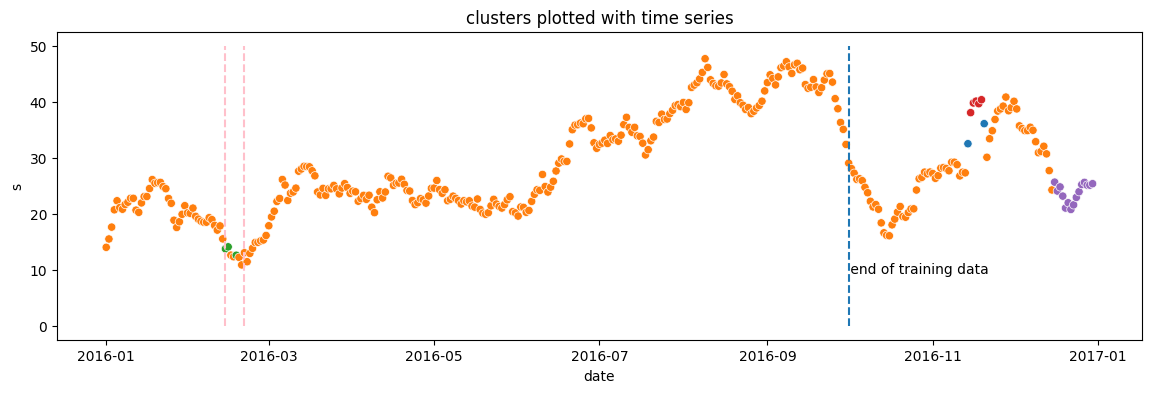

In [88]:
# making use of 5 original sensor columns given to classify anomalous data using DBSCAN
# this is the final model to be used because the visualization matches with the constraint: 
# analyst marked on a certain time period of time series as anomalous
# it is being taken for granted no other period was anomalous in the time series
# for the first 9 months apart from the one marked by the analyst

from sklearn.cluster import DBSCAN
classifier = DBSCAN(2.2,min_samples=3)
time_series['cluster'] = classifier.fit_predict(time_series[original_cols])
plt.figure(figsize=(14,4))
plt.vlines(x=pd.to_datetime('2016-02-14'),ymin=0,ymax=50,linestyles='dashed',color='pink')
plt.vlines(x=pd.to_datetime('2016-02-21'),ymin=0,ymax=50,linestyles='dashed',color='pink')
plt.vlines(x=pd.to_datetime('2016-10-01'),ymin=0,ymax=50,linestyles='dashed')
plt.text(pd.to_datetime('2016-09-30'), 10, " end of training data", rotation=0, verticalalignment='center')
sns.scatterplot(data=time_series,x=time_series.date,y='s',hue='cluster', palette="tab10",legend=False)
plt.title('clusters plotted with time series')

In [86]:
# # save the model as pickle file
# # only uncomment if want to save the model again
# import pickle
# # save
# with open('anomaly_detector.pkl','wb') as f:
#     pickle.dump(classifier,f)

# # load
# import pickle
# with open('wind_forecast_model.pkl', 'rb') as f:
#     model = pickle.load(f)

# classifier.predict(X[0:1])

In [87]:
# putting required constraints on resulted anomalies before putting it into required json format
# as required for the api
a = pd.DataFrame({'a':time_series['cluster'],'date':time_series.index})
a['a'] = time_series.cluster != mode(time_series.cluster)[0]
a['sess'] = a['a'].diff()
a.loc[a['a']==False, 'sess'] = np.nan
a.sess = a.sess.cumsum()
a = a.groupby('sess').agg(
    consecutive_days = ('a','count'),
    start_date = ('date','first'),
    end_date = ('date','last')
)
display(a)
a = a.loc[a['consecutive_days']>2]
a.to_json(orient='records')

,consecutive_days,start_date,end_date
sess,,,
1.0,2,44,45
2.0,1,48,48
3.0,7,318,324
4.0,15,350,364


'[{"consecutive_days":7,"start_date":318,"end_date":324},{"consecutive_days":15,"start_date":350,"end_date":364}]'